<a href="https://colab.research.google.com/github/dbabrams/ShallowDolomite_Group/blob/waterbudget%2Fpu/Summer2020_Model/WillCounty_Summer2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>FloPy Regional Model Development</center>
The following script develops a regional MODFLOW model using FloPy and associated packages. The study domain is the Mahomet Aquifer in Illinois, particulary in the heavily irrigated region of Mason County. 

Note that you may not always have to compile MODFLOW, and you only have initialize code (#1) and import large files (#2) the first time you run the code in a session. Most of the time, you will only have to run #3 onward. 

# 0. Compile MODFLOW (DO NOT RUN UNLESS NECESSARY)


When using Google CoLab, you cannot simply use an existing MODFLOW executable, but have to compile a a new one for use in this environment. I have already compiled MODFLOW, but am currently unsure if it will work for everybody. Please do not run the following code unless you get an error that the MODFLOW file was not found (will occur when running the model). 

In [0]:
#!pip install https://github.com/modflowpy/pymake/zipball/master # install of the pymake package to compile MODFLOW

In [0]:
# Code to complile the MODFLOW executable

#import pymake

#def make_mf2005():
#    pymake.build_apps('mf2005')


#if __name__ == "__main__":
#    make_mf2005()



#MF-NWT has more robust handling of dry cells

#import pymake

#def make_mfnwt():
#    pymake.build_apps('mfnwt')

#if __name__ == "__main__":
#    make_mfnwt()


# 1 Initializing the code


These few code blocks only have to be run at the beginning of the script or if a runtime connection is lost. See details for each below. 

## 1A. Install needed packages
There are three packages that must be installed in the CoLab environment to run this script. These include 

"pyproj", which allows for the conversion from WGS84 coordinates (as obtained from Google Earth), which are in lat/long decimal degrees, to Illimap coordinates, a specialized projection using Lambert Conformal Conic that is optimized for developing a model grid in the state of Illinois. 

"flopy" creates modflow executables, runs the model, and allows for manipulation of results.

"rasterio" allows for the reading of raster files, and is closely tied to the development of "flopy" input files


In [1366]:
!pip install pyproj
!pip install flopy
!pip install rasterio
!pip install pykrige
!apt-get -qq install python-cartopy python3-cartopy

## 1B. Import packages

In [0]:
import flopy # import flopy to develop, run, and analyze the model
from flopy.utils import Raster # plot rasters from flopy
import matplotlib as mp
import pandas as pd
import pyproj # change between WGS84 and Illimap coordinates
import rasterio  # import rasters
import matplotlib.pyplot as plt
import numpy as np 

# the following code authorizes you to access files on Google Drive
from google.colab import drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from pykrige.uk import UniversalKriging
import cartopy.crs as ccrs
import cartopy.feature as cf

## 1C. Authenticate with Google
This will allow you to access shared files on my Google Drive or your own. 

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## 1D. Read the MODFLOW executable from Google Drive

Here you are going to download the MODFLOW executable from Daniel's Google Drive. This will show up in your temporary working directory for use later in the code. <b>We need to confirm whether this will work in CoLab, or if you need to compile a new version of MODFLOW each time.</b>

Note that this makes use of a key on your Google Drive sharable link for the file. This generally takes the form of: https://drive.google.com/file/d/**key**/view?usp=sharing, in this case, key = 1SwqsSCvyrnrCiopeEp52LBcZYNcgBT9V

In [0]:
downloaded = drive.CreateFile({'id':"1SwqsSCvyrnrCiopeEp52LBcZYNcgBT9V"}) # This is the key that is defined in the sharable link of a file on Google Drive
downloaded.GetContentFile('mf2005') # get the content from Google Drive and name it (let's stick with mf2005 here)

#downloaded = drive.CreateFile({'id':"1iThxRoGVhofLPd8HOF7Vn0awRVrXZcVb"}) # This is the key that is defined in the sharable link of a file on Google Drive
#downloaded.GetContentFile('mfnwt') # get the content from Google Drive and name it (let's stick with mf2005 here)

Now we need to copy the executable into a location where we can later run it. Note that the "!" nomenclature is a shell command, beyond the scope of this course to learn that!

In [0]:
!cp mf2005 /usr/local/bin
!chmod 755 /usr/local/bin/mf2005

#!cp mfnwt /usr/local/bin
#!chmod 755 /usr/local/bin/mfnwt

# 2 Import the big stuff


We don't want to repeatedly import large files for fear of Google revoking our CoLab priveleges for a few hours. Once or twice isn't a big deal, but repeatedly might be an issue. Let Daniel know if this happens- there are ways to reduce our file sizes. 

For now, the "big stuff" includes a DEM of Illinois and the river excel file we worked with last time. 

## 2A. Import the DEM

Refer to this link：

https://pythonhosted.org/PyDrive/filemanagement.html  

In [0]:
# first import the land surface .tif from Google Drive
downloaded = drive.CreateFile({'id':"1389l8sgQ8-tsmIZuZosaqvbqpHY40n6l"}) # ft above msl
downloaded.GetContentFile('landsurface_el.tif')

# first import the bedrock elevation .tif from Google Drive
downloaded = drive.CreateFile({'id':"1EZgZDjjILzvRzvY9nf0Qp0NHmspRq4kP"})   
downloaded.GetContentFile('bedrock_el.tif')

# read in percent thickness of coarse grain for each model layer
downloaded = drive.CreateFile({'id':"18Kw3O6qCzIJ2L6KrVnRPIhea_F8VwyWn"})   
downloaded.GetContentFile('percentl1.tif')

downloaded = drive.CreateFile({'id':"1oZinFPKrGY-FXoE7Zu0okFpAAOe_bwau"})   
downloaded.GetContentFile('percentl2.tif')

downloaded = drive.CreateFile({'id':"1FqVEr4m_ElUyEZeyfnCMwVGDfUqavJZH"})   
downloaded.GetContentFile('percentl3.tif')

downloaded = drive.CreateFile({'id':"1KiHS9TLSP1GAVTjaaJZS4BAwF6gnUeDu"})   
downloaded.GetContentFile('percentl4.tif')

downloaded = drive.CreateFile({'id':"1Z-9EyaAK1NKnRHAlnyGYkI3suvBFC2I6"})   
downloaded.GetContentFile('percentl5.tif')

downloaded = drive.CreateFile({'id':"1pcB9aJpJGfkXOKz10rhs6MpWkQL1_dqr"})   
downloaded.GetContentFile('percentl6.tif')

downloaded = drive.CreateFile({'id':"1Fnh0HIKbUj7pEtlsUKR_Sr7WwfYzWul5"})   
downloaded.GetContentFile('percentl7.tif')

downloaded = drive.CreateFile({'id':"106JacgpwSA3wVAGcBIzGdc8rDVUB6dh7"})   
downloaded.GetContentFile('percentl8.tif')

downloaded = drive.CreateFile({'id':"1WJjhVJ_KSBhZDrgzY3YteNjxaz5nxBid"})   
downloaded.GetContentFile('percentl9.tif')

## 2B. Import the river file

In [0]:
# first import the Excel file from Google Drive
downloaded = drive.CreateFile({'id':"1JsAiGG4RvcfYrQtfgXRW9ZVfAkQ1yRVu"})
downloaded.GetContentFile('rivers_625.csv')

# 3 Create MODFLOW  packages

## 3A. Model Set-up

### 3Ai. Define the Model Domain

In [1373]:
#----------------------------------------------------------------------------
# Define model domain in lat/long coordinates

# new model domain (2020.6.2)
sw_lat = 41.356272  #southwest latitude
sw_long = -88.311217 #southwest longitude
ne_lat = 41.701295  #northeast latitude
ne_long = -87.831109 #northeast longitude

"""
# Will County coordinates for each corner of the domain
sw_lat =  41.41 #southwest latitude
sw_long = -88.24 #southwest longitude
ne_lat =  41.73 #northeast latitude
ne_long = -88.03 #northeast longitude

# North (upper) part of Will County Model
# Zone 1
sw_lat =  41.57 #southwest latitude
sw_long = -88.24 #southwest longitude
ne_lat =  41.73 #northeast latitude
ne_long = -88.03 #northeast longitude

# South (lower) part of Will County Model
# Zone 2
sw_lat =  41.41 #southwest latitude
sw_long = -88.24 #southwest longitude
ne_lat =  41.57 #northeast latitude
ne_long = -88.03 #northeast longitude
"""


illimap = {'proj': 'lcc', # code for Lambert Conformal Conic
     'ellps': 'clrk66',
     'lon_0': -89.5,
     'lat_0': 33,
     'lat_1': 33,
     'lat_2': 45,
     'x_0': 2999994*0.3048,
     'y_0': 0}

# refer to https://pyproj4.github.io/pyproj/stable/api/proj.html
prj = pyproj.Proj(illimap) # form domain in illimap coordinates

wgs84 = pyproj.Proj("epsg:4326") # convert to wgs84 projection

nex, ney = pyproj.transform(wgs84,illimap,ne_lat,ne_long) 
swx, swy = pyproj.transform(wgs84,illimap,sw_lat,sw_long)


nex, ney = round(nex/0.3048,-4), round(ney/0.3048,-4)
swx, swy = round(swx/0.3048,-4), round(swy/0.3048,-4)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:47: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1


### 3Aii. Define spatial and temporal discretization

In [0]:
# Assign Discretization variables
Lx = nex-swx # Width of the model domain in meters
Ly = ney-swy # Height of the model domain in meters
nlay = 10 # Number of model layers
dx = 2000 
dy = 2000
nrow = int(Ly/dy) # Number of rows
ncol = int(Lx/dx) # Number of columns

nper = 1 #specify number of stress periods
steady = [True] #specify if stress period is transient or steady-state


### 3Aiii. Define river elevations



In [0]:
# import river stage, lambert x, lambert y from river Excel file
dfriv = pd.read_csv('rivers_625.csv')

# trim dataframe with river information to the model domain
dfriv = dfriv.loc[dfriv['lamx']<nex]
dfriv = dfriv.loc[dfriv['lamy']<ney]
dfriv = dfriv.loc[dfriv['lamx']>swx]
dfriv = dfriv.loc[dfriv['lamy']>swy]

# assign all rivers to the upper layer
dfriv['lay'] = 0 #this actually assigns it to layer 1
# convert lamx to column and lamy to row
dfriv['row'] = np.trunc((ney-dfriv['lamy'])/dy)
dfriv['col'] = np.trunc((dfriv['lamx']-swx)/dx)
# define the river stage
dfriv['stage'] = dfriv['rvr_stg']
#define the conductance
dfriv['cond'] = 90000. # ft^2/d (this number has been changed due to calibration)
# define the river bottom
dfriv['bot'] = dfriv['stage']-3
# drop unneeded columns
dfriv = dfriv.drop(['STR_ORD_MI','STR_ORD_MA','SUM_LENGTH','rvr_stg','lamx','lamy'],axis=1)

# group duplicate rivers within a cell
dfriv = dfriv.groupby(['lay','row','col'],as_index=False).mean()

In [1376]:
dfriv.head()

,lay,row,col,stage,cond,bot
0,0,0.0,21.0,631.020004,90000.0,628.020004
1,0,0.0,22.0,623.809998,90000.0,620.809998
2,0,0.0,23.0,621.468005,90000.0,618.468005
3,0,0.0,24.0,622.726001,90000.0,619.726001
4,0,0.0,48.0,604.615005,90000.0,601.615005


### 3Aiv. Define top and bottom elevations

In [0]:
# Now load the raster using FloPy's built in Raster toolbox
illinoisdem = Raster.load("landsurface_el.tif")
bedrock = Raster.load("bedrock_el.tif")

# Crop the DEM to the model domain
illinoisdem.crop([(swx,swy),(swx,ney),(nex,ney),(nex,swy)])
bedrock.crop([(swx,swy),(swx,ney),(nex,ney),(nex,swy)])
# Define centroid of the southwestern most cell
startx = swx+dx/2 
starty = swy+dy/2
# Calculate the x and y coordinates for the centroid of each cell 
xc = np.arange(swx+dx/2,nex+dx/2,dx) 
yc = np.arange(swy+dy/2,ney+dy/2,dy)
# Create a grid of the x coordinate of each centroid and the y coordinate
xarr, yarr = np.meshgrid(xc,yc)
# resample the topo raster to the grid of centroids of the model
topgrid = illinoisdem.resample_to_grid(xarr,yarr,1,method='nearest') 
bedrock = bedrock.resample_to_grid(xarr,yarr,1,method='nearest')

# We built our top elevation upside down, let's flip it
topgrid = np.flipud(topgrid) 
bedrockgrid = np.flipud(bedrock)   

# Create ibound as array of ints (1), indicating all cells are active
# inactivate cells west of the Mississippi River that were originally not present
# note that because inactive cells would overlap with the river boundaries, this code pushes inactive cells to the west a bit. Adjsut per your model domain
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)

In [0]:
# Set the top of Layer 1 = River Elevation
for index, row in dfriv.iterrows():  
    topgrid[int(row['row']),int(row['col'])]=row['stage'] 
    #print(topgrid[int(row['row']),int(row['col'])],row['bot'])  

# make sure that all layers (combined) are at least 9 ft thick
diff = topgrid-bedrockgrid

diff[diff<=9.0] = 9.0

# each layer EXCEPT BEDROCK is the same thickness, we need 9 glacial layers
laythick = diff/9 #glacial layers
bothick = 50. #thickness of bedrock. May need to change?? look at report?

#calculate bottom of each layer
lay1bot = topgrid-laythick
lay2bot = topgrid-2*laythick
lay3bot = topgrid-3*laythick
lay4bot = topgrid-4*laythick
lay5bot = topgrid-5*laythick
lay6bot = topgrid-6*laythick
lay7bot = topgrid-7*laythick
lay8bot = topgrid-8*laythick
lay9bot = topgrid-9*laythick
lay10bot = lay9bot-bothick 

botgrids = [lay1bot,lay2bot,lay3bot,lay4bot,lay5bot,lay6bot,lay7bot,lay8bot,lay9bot,lay10bot]

### 3Av. Assign hydraulic conductivity

In [0]:
# assign hydrualic conductivity in ft/day
kc = 150 # predominantly coarse
kf = 0.8 # predominantly fine
kb = 50 # bedrock

# determine how to assign hydrualic conductivity
threshold = 25 # anything above this will be assigned kc;below kf

def kloader(rastername, kc, kf, threshold):
  percent = Raster.load(rastername) # load raster
  percent.crop([(swx,swy),(swx,ney),(nex,ney),(nex,swy)]) # crop array
  percentgrid = percent.resample_to_grid(xarr,yarr,1,method='nearest') # resample to model grid
  percentgrid = np.flipud(percentgrid) # flip the grid
  maxrow = percentgrid.shape[0]
  maxcol = percentgrid.shape[1]
  for row in np.arange(maxrow,0,-1):
    for col in np.arange(maxcol,0,-1):
      if percentgrid[row-1,col-1] < -10:
        percentgrid[row-1,col-1] = percentgrid[row-1,col]
  percentgrid[percentgrid>=threshold] = kc # assign coarse k value
  percentgrid[percentgrid<threshold] =kf # assign fine k value
  return percentgrid

kl1 = kloader('percentl1.tif',kc,kf,threshold)
kl2 = kloader('percentl2.tif',kc,kf,threshold)
kl3 = kloader('percentl3.tif',kc,kf,threshold)
kl4 = kloader('percentl4.tif',kc,kf,threshold)
kl5 = kloader('percentl5.tif',kc,kf,threshold)
kl6 = kloader('percentl6.tif',kc,kf,threshold)
kl7 = kloader('percentl7.tif',kc,kf,threshold)
kl8 = kloader('percentl8.tif',kc,kf,threshold)
kl9 = kloader('percentl9.tif',kc,kf,threshold)
kl10 = kl9-kl9+kb

khlayers = [kl1,kl2,kl3,kl4,kl5,kl6,kl7,kl8,kl9,kl10]
kvlayers=np.divide(khlayers,10.)

### 3Avi. Define wells

In [0]:
# import well data from csv file
dfwell = pd.read_csv('https://raw.githubusercontent.com/dbabrams/ShallowDolomite_Group/master/pumping/2002_pumping_V2.csv?token=AOLRDK5ADZIXTFILFI2RKQ264BNAQ')
dfwell = dfwell.set_index('p_num') #assign index as p_number so that other columns can be deleted

# trim dataframe with well information to the model domain
dfwell = dfwell.loc[dfwell['lam_x']<nex]
dfwell = dfwell.loc[dfwell['lam_y']<ney]
dfwell = dfwell.loc[dfwell['lam_x']>swx]
dfwell = dfwell.loc[dfwell['lam_y']>swy]

# put the data into the format required for the well package, with columns for layer, row, column, and flux
# assign all wells to bedrock layer (10 layers but starts at 0 so the last layer is 9)
dfwell['lay'] = 9
# convert lamx to column and lamy to row
dfwell['row'] = np.trunc((ney-dfwell['lam_y'])/dy)
dfwell['col'] = np.trunc((dfwell['lam_x']-swx)/dx)
# define the flux as the pumpage data from the imported file and convert from gal/year to ft3/day to match other units of the model. Also, make it negative so that it detracts from system.
dfwell['flux']=dfwell['2002']*-1/2730

# drop unneeded columns
dfwell = dfwell.drop(['isws_facility_id','owner','fac_well_num','depth_total_last_known','lam_x','lam_y','2002'], axis=1)

#print(dfwell)

###3Avii. Define Drains

In [1381]:
#Assign drain package to all cells in L1 which have hydraulic conductivity = kf. This low-k material is at land surface.
#return the row # and column # for each element in kl1 where that element is equal to kf, in the form of a ndarray of row #s & another ndarray of col #s
rows,cols = np.nonzero(kl1==kf)
# create dataframe the same length as "rows" with a single column of zeros called 'lay' which assigns all drain cells to the upper layer
drains = pd.DataFrame(np.zeros((len(rows), 1)),columns=['lay'])
# add drain cell element column #s and row #s
drains['row'] = rows 
drains['col'] = cols
# define each drain cell elevation (set to land surface)
drains['elevation']=0
for index, row in drains.iterrows():
  drains.loc[index,'elevation']=topgrid[int(row['row']),int(row['col'])]
#define the conductance
# drains['cond'] = kf*100*(dx+dy)*0.3048/1.5 # 2 orders of magnitude higher than kf (ft^2/d). kf is in ft/d, so multiply by the mean of dx & dy (*0.3048 ft/m)
drains['cond'] = kf * dx * dy / 3
# https://riverware.org/HelpSystem/index.html#page/Objects/groundwaterStorage.16.05.html

# drop drain cells where they have already been assigned as river cells
# add a new column ['rowcol_num'] with a unique identifier for each cell
drains['rowcol_num'] = 1000*drains['row']+drains['col']
dfriv['rowcol_num'] = 1000*dfriv['row']+dfriv['col']
rowcol_num = dfriv['rowcol_num'].tolist()
row_ori = drains.shape[0]
# drop cells with the same ['rowcol_num'] in both drains and rivers
drains = drains.drop(drains.loc[drains['rowcol_num'].isin(rowcol_num)].index)
row_new = drains.shape[0]
del drains['rowcol_num']
del dfriv['rowcol_num']
print(row_ori-row_new,'rows are removed')

440 rows are removed


In [1382]:
drains

,lay,row,col,elevation,cond
0,0.0,0,0,660.100586,1.066667e+06
1,0.0,0,1,662.346069,1.066667e+06
2,0.0,0,2,663.211853,1.066667e+06
3,0.0,0,3,668.553101,1.066667e+06
4,0.0,0,4,713.301086,1.066667e+06
...,...,...,...,...,...
3905,0.0,64,60,708.958252,1.066667e+06
3906,0.0,64,61,703.795227,1.066667e+06
3907,0.0,64,62,700.051208,1.066667e+06
3908,0.0,64,63,705.711548,1.066667e+06


## 3B. Create the MODFLOW model object 

In [0]:
# Create a MODFLOW model object and run with MODFLOW 2005.
modelname = "my_model" # name the model
m = flopy.modflow.Modflow(modelname, version = 'mf2005', exe_name = 'mf2005') # create model object m

## 3C. Append the discretization package to the model object

In [0]:
# length and time are feet (1) and days (4).
# See https://water.usgs.gov/ogw/modflow/MODFLOW-2005-Guide/index.html?dis.htm 
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=topgrid, botm=botgrids, 
                               itmuni = 4, lenuni = 1, 
                               nper=nper, steady=steady)

## 3D. Basic Package

In [0]:
# Create ibound as array of ints (1), indicating all cells are active
#ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)

#Create flopy bas object
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=topgrid)


## 3E. LPF Package

In [0]:
#define layer type as convertible (1), must be an integer
#for more information, see https://water.usgs.gov/ogw/modflow/MODFLOW-2005-Guide/index.html?dis.htm
laytyp = 0*np.ones((nlay,), dtype=np.int32)

# create the LPF object
lpf = flopy.modflow.ModflowLpf(model=m, hk=khlayers, vka=kvlayers, laytyp=laytyp, ipakcb=1)


## 3F. Boundary Conditions

### 3Fi. Recharge Package

In [0]:
# assign recharge to the model
#units=ft/d

rch1=0.0014 #fine
rch2=0.0024 #coarse

#create recharge array corresponding with values in kl1 (toplayer) array, where
#when kl1 element=kf, then recharge element=rch1, and when kl1 element does not equal kf (it is kc), then recharge element=rch2
recharge=np.where(kl1<=kf, rch1, rch2) 

#create recharge package
rch = flopy.modflow.mfrch.ModflowRch(model=m,nrchop=1, rech = recharge) #nrchop=1 assigns recharge to top grid layer only

### 3Fii. River Package

In [0]:
# put into a format that MODFLOW wants
arriv = dfriv.values
#dictionary assigning river data; #key (0) is the stress period
#stress period is how you're breaking up time
riverdata = {0: arriv} #model ready river data

# create river package
riv = flopy.modflow.mfriv.ModflowRiv(model=m, ipakcb=None,stress_period_data=riverdata)

### 3Fiii. Drain Package


In [0]:
# put into a format that MODFLOW wants. uses data from drain set up above
mfdrn = drains.values

#model ready drains data as a dictionary with 0 as the stress period
drainsdata = {0: mfdrn}

# create drains package
drn = flopy.modflow.mfdrn.ModflowDrn(model=m, ipakcb=None, stress_period_data=drainsdata)

### 3Fiv. Well Package

In [0]:
# put into a format that MODFLOW wants as a dictionary with the values from the well dataframe created in the section above.
arwell = dfwell.values
welldata = {0: arwell} #dictionary assigning well data and a single stress period =0 (steady state)

# create well package 
well = flopy.modflow.mfwel.ModflowWel(model=m, ipakcb=None,stress_period_data=welldata)

### 3G. Define output control

In [0]:
#create oc stress period data. 
spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}
#create output control object
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=spd, compact=True)

## 3H. Solver

In [0]:
# We will start by using the PCG solver with default settings
#pcg = flopy.modflow.ModflowPcg(model=m)
pcg = flopy.modflow.ModflowPcg(model=m,mxiter=200,iter1=50,hclose=1e-03,rclose=1e-03,relax=0.98,damp=0.3)

## 3I. Plot model inputs (boundary conditions, elevations)

In [0]:
"""Create meshgrids for the model, they will be used in maps with a color flood."""
# x and y are located on the centeroid of each grid
x = xc - np.min(xc) + dx / 2
y = yc - np.min(yc) + dy / 2
X, Y = np.meshgrid(x, y)

/usr/local/lib/python3.6/dist-packages/flopy/plot/map.py:525: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pa[list(idx[1:])] = 1


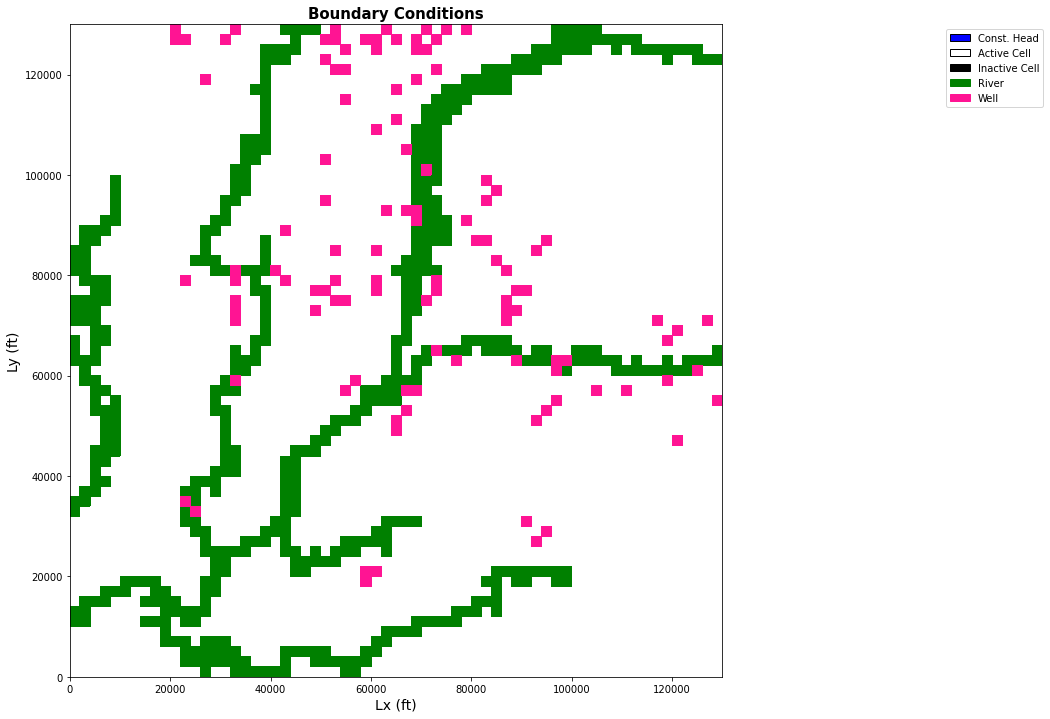

In [1394]:
'''Plot grid and boundary conditions'''
#----------------------------------------------------------------------------
plt.figure(figsize=(12,12)) #create 12 x 12 figure
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
#grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
rvr = modelmap.plot_bc(ftype='RIV')
wel = modelmap.plot_bc(ftype='WEL',color='deeppink',plotAll=True)
#add labels and legend
plt.xlabel('Lx (ft)',fontsize = 14)
plt.ylabel('Ly (ft)',fontsize = 14)
plt.title('Boundary Conditions', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black'),
                   mp.patches.Patch(color='green',label='River',ec='green'),
                   mp.patches.Patch(color='deeppink',label='Well')],
                   bbox_to_anchor=(1.5,1.0))
plt.show()
#----------------------------------------------------------------------------

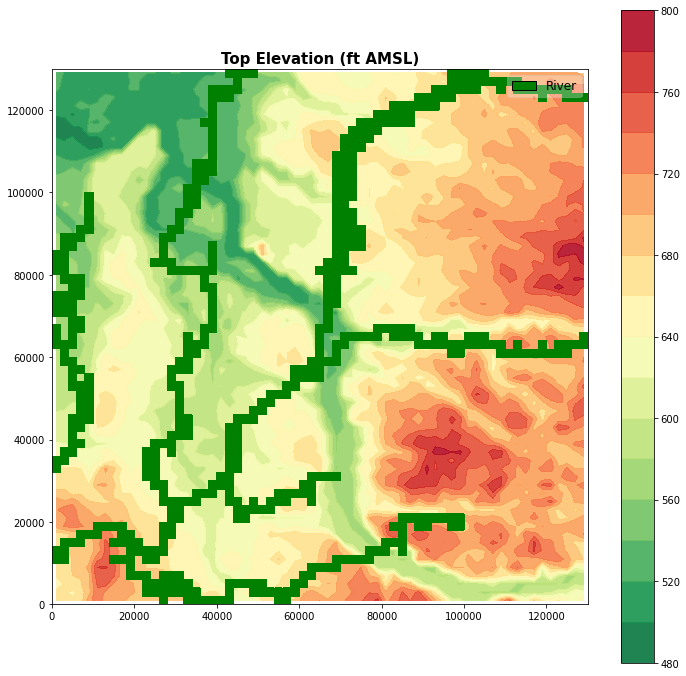

In [1395]:
"""Plot top elevation"""
plt.figure(figsize=(12,12)) #create 12 x 12 figure
modelmap = flopy.plot.PlotMapView(model=m, layer=0) #use plotmapview to attach plot to model
plt.title('Top Elevation (ft AMSL)',fontsize=15,fontweight='bold')

# Create a color flood and add colorbar
plt.colorbar(plt.contourf(X, Y, topgrid, 16, alpha=0.9, cmap=plt.cm.RdYlGn_r))
# add ibound and a river
ib = modelmap.plot_ibound()
rvr = modelmap.plot_bc(ftype='RIV',color='green')
plt.legend(handles=[mp.patches.Patch(color='green',label='River',ec='black')],
           framealpha=0.3, fontsize=12,loc='best')
plt.show()

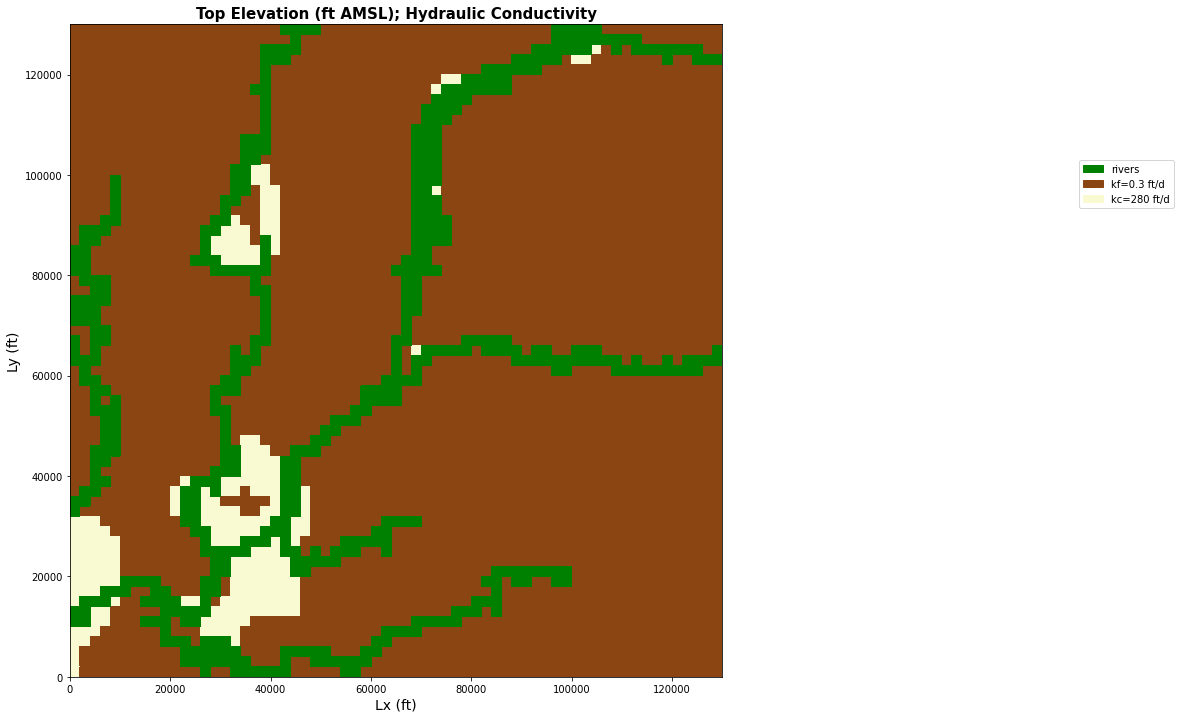

In [1396]:
'''Plot hydraulic conductivity'''
#----------------------------------------------------------------------------
plt.figure(figsize=(12,12)) #create 12 x 12 figure
modelmap = flopy.plot.map.PlotMapView(model=m, layer=0) #use plotmapview to attach plot to model
#contour_levels = np.linspace(400,800,41)
#topelevations = modelmap.contour_array(topgrid, levels = contour_levels) #create head contours
#plt.clabel(topelevations, inline=True,fontsize=12,fmt='%1.0f')

#create colormap of named colors
colors = ["saddlebrown","lightgoldenrodyellow"]
cmap = mp.colors.LinearSegmentedColormap.from_list("", colors)
norm = mp.colors.LogNorm(vmin=kf,vmax=kc)
modelmap.plot_array(khlayers[0],norm = norm,cmap=cmap)
rvr = modelmap.plot_bc(ftype='RIV')
ib = modelmap.plot_ibound()
#display parameters
plt.xlabel('Lx (ft)',fontsize = 14)
plt.ylabel('Ly (ft)',fontsize = 14)
plt.title('Top Elevation (ft AMSL); Hydraulic Conductivity', fontsize = 15, fontweight = 'bold')

#Create a legend for the hydraulic conductivity
plt.legend(handles=[
  mp.patches.Patch(color='green', label='rivers'),
  mp.patches.Patch(color='saddlebrown', label='kf=0.3 ft/d'),
  mp.patches.Patch(color='lightgoldenrodyellow', label='kc=280 ft/d') ], bbox_to_anchor=(1.7,0.8))
plt.show()

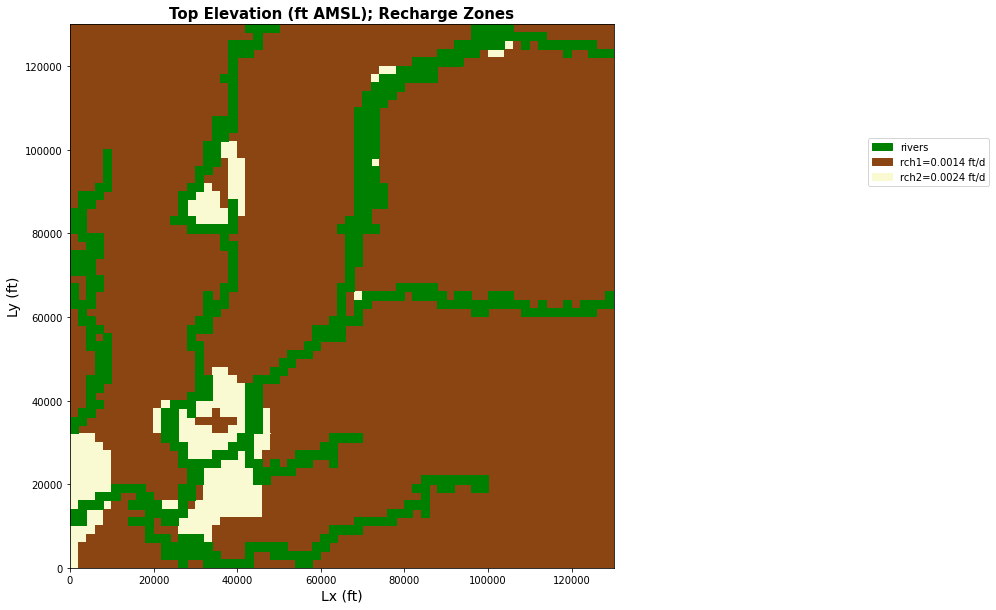

In [1397]:
'''Plot recharge'''
#----------------------------------------------------------------------------
fig=plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelmap = flopy.plot.map.PlotMapView(model=m, layer=0) #use plotmapview to attach plot to model
#contour_levels = np.linspace(400,800,41)
#topelevations = modelmap.contour_array(topgrid, levels = contour_levels) #create head contours
#plt.clabel(topelevations, inline=True,fontsize=12,fmt='%1.0f')

#create colormap of named colors
colors = ["saddlebrown","lightgoldenrodyellow"]
cmap = mp.colors.LinearSegmentedColormap.from_list("", colors)
norm = mp.colors.LogNorm(vmin=rch1,vmax=rch2)
pcm=modelmap.plot_array(recharge, norm = norm,cmap=cmap)
rvr = modelmap.plot_bc(ftype='RIV')
ib = modelmap.plot_ibound()
#display parameters
plt.xlabel('Lx (ft)',fontsize = 14)
plt.ylabel('Ly (ft)',fontsize = 14)
plt.title('Top Elevation (ft AMSL); Recharge Zones', fontsize = 15, fontweight = 'bold')

#Create a legend for the recharge zones 
plt.legend(handles=[
  mp.patches.Patch(color='green', label='rivers'),
  mp.patches.Patch(color='saddlebrown', label='rch1=0.0014 ft/d'),
  mp.patches.Patch(color='lightgoldenrodyellow', label='rch2=0.0024 ft/d') ], bbox_to_anchor=(1.7,0.8))
plt.show()

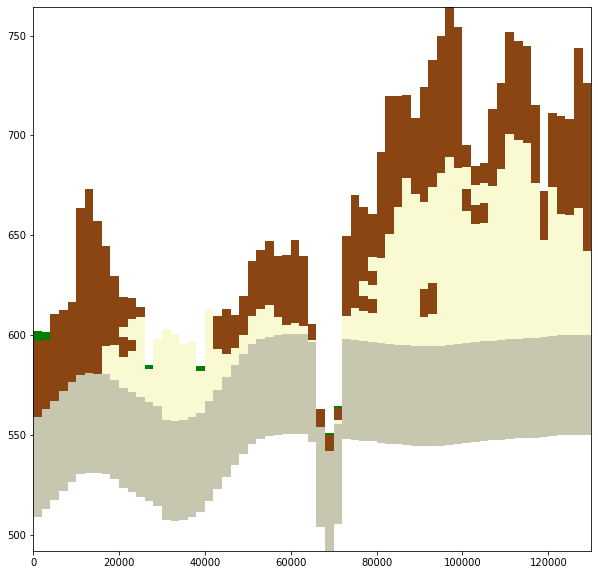

In [1398]:
'''Plot transects'''
#----------------------------------------------------------------------------
plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelxsect = flopy.plot.PlotCrossSection(model = m, line={"row":22}) #use plotmapview to attach plot to model. row indicates west to east 
#modelxsect = flopy.plot.PlotCrossSection(model = m, line={"column":15}) #plots north-south transect
#create colormap of named colors
colors = ["saddlebrown","gray","lightgoldenrodyellow"]
cmap = mp.colors.LinearSegmentedColormap.from_list("", colors)
norm = mp.colors.LogNorm(vmin=kf,vmax=kc)
#modelxsect.plot_grid()
khlaynp = np.array(khlayers)
lines = modelxsect.plot_array(khlaynp,norm=norm, cmap=cmap)
rvr = modelxsect.plot_bc(ftype='RIV')
modelxsect.plot_ibound()

## ESL way of ploting transmissivity

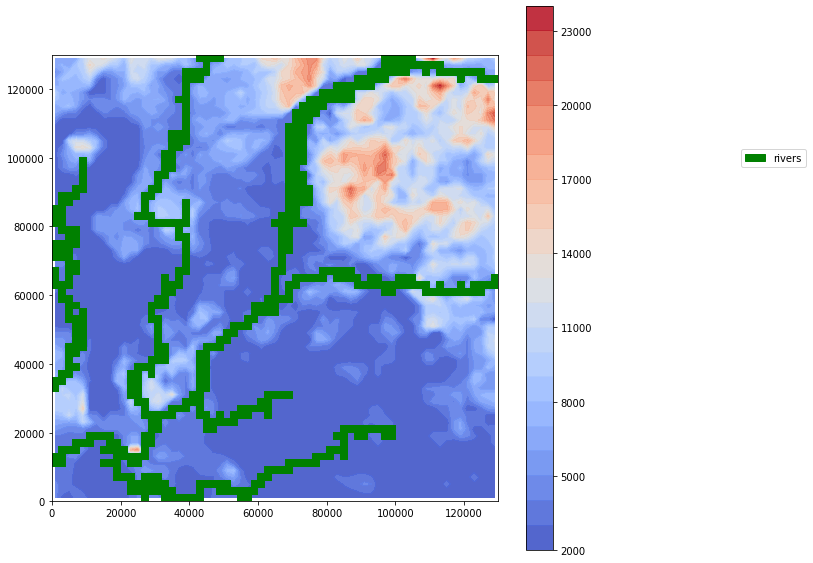

In [1399]:
'''Plot Transmissivity'''
#Horizontal T = sum k of each layer * layer thickness
Thz=sum([k for k in khlayers])*laythick-kl10*laythick+kl10*bothick
T_flipped = np.flipud(Thz)
#----------------------------------------------------------------------------
plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelmap = flopy.plot.map.PlotMapView(model=m, layer=0) #use plotmapview to attach plot to model
plt.colorbar(plt.contourf(X, Y, T_flipped, 20, alpha=0.9,
                          cmap=plt.cm.coolwarm))  # Plot the transmissivity
rvr = modelmap.plot_bc(ftype='RIV')                      
plt.legend(handles=[mp.patches.Patch(color='green', label='rivers')], bbox_to_anchor=(1.7,0.8))

plt.show()

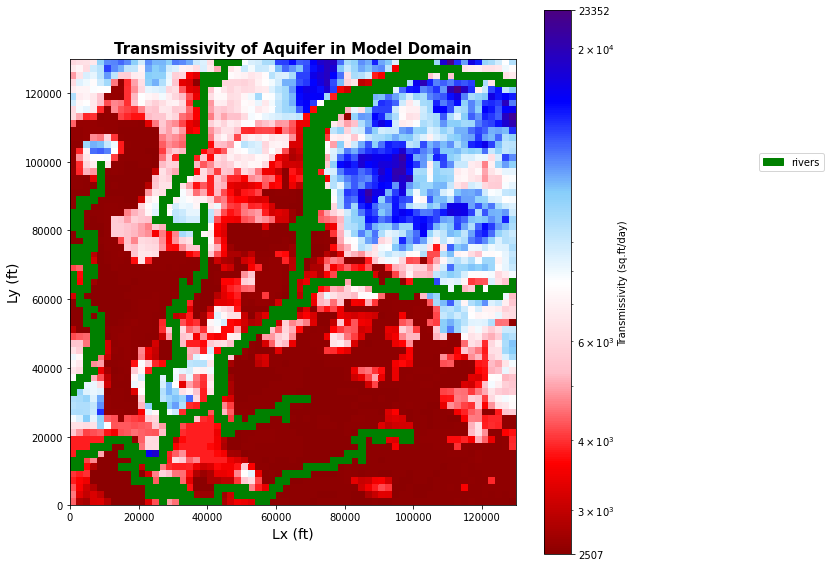

In [1400]:
'''Plot Transmissivity'''
#Horizontal T = sum k of each layer * layer thickness
Thz=sum([k for k in khlayers])*laythick-kl10*laythick+kl10*bothick
#---------------------------------------------------------------------------
plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelmap = flopy.plot.map.PlotMapView(model=m, layer=0) #use plotmapview to attach plot to model

# create colormap of named colors
colors = ["darkred","red","pink","white","lightskyblue","blue","indigo"]
cmap = mp.colors.LinearSegmentedColormap.from_list("", colors)
norm = mp.colors.LogNorm(vmin=np.amin(Thz),vmax=np.amax(Thz))
Tmap=modelmap.plot_array(Thz,norm = norm,cmap=cmap)
rvr = modelmap.plot_bc(ftype='RIV')
#display parameters
plt.xlabel('Lx (ft)',fontsize = 14)
plt.ylabel('Ly (ft)',fontsize = 14)
plt.title('Transmissivity of Aquifer in Model Domain', fontsize = 15, fontweight = 'bold')
cbar = plt.colorbar(Tmap,ticks=[np.amin(Thz),np.amax(Thz)], label='Transmissivity (sq.ft/day)')
cbar.set_ticklabels([int(round(np.amin(Thz),0)),int(round(np.amax(Thz),0))])
plt.legend(handles=[mp.patches.Patch(color='green', label='rivers')], bbox_to_anchor=(1.7,0.8))
plt.show()

# 4 Write and run the MODFLOW model

In [1401]:
# Write the model input
m.write_input()
# Execute the model run
success, mfoutput = m.run_model(pause=False, report=True)
# Report back if the model did not successfully complete
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following  executable to run the model: /usr/local/bin/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: my_model.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/06/08  1:00:55

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2020/06/08  1:00:59
 Elapsed run time:  3.351 Seconds

  Normal termination of simulation


# 5 Plot Output Data

In [0]:
'''Extract binary data from head and flow files'''
#----------------------------------------------------------------------------
#extract binary data from head file as flopy head object
headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds')
#extract head data from head object
head = headobj.get_data(totim=1.0)
#print(head[9]) #returns the last layer heads which is where the pumping takes effect


/usr/local/lib/python3.6/dist-packages/flopy/plot/map.py:525: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pa[list(idx[1:])] = 1


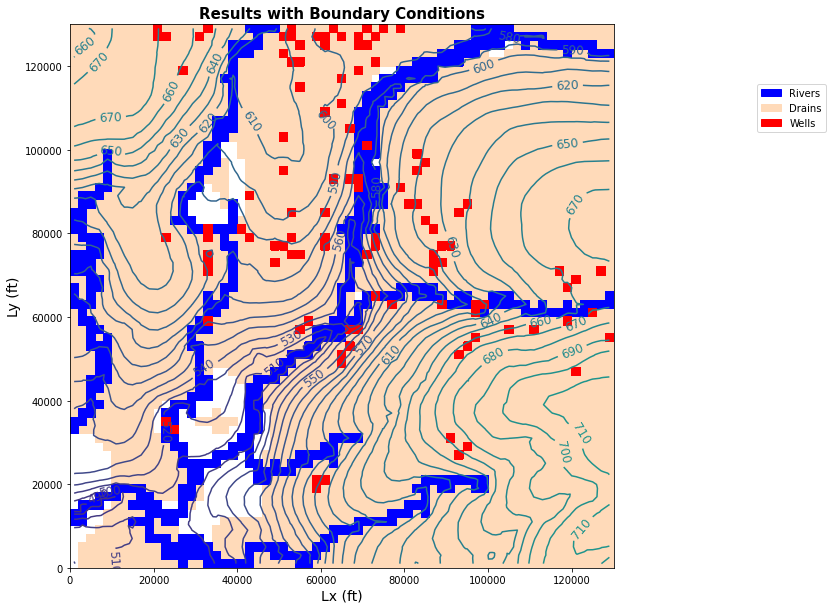

In [1403]:
'''Plot results with boundary conditions'''
#----------------------------------------------------------------------------
plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelmap = flopy.plot.map.PlotMapView(model=m, layer=0) #use plotmapview to attach plot to model
contour_levels = np.linspace(400,1000,61) #set contour levels for contouring head
head_contours = modelmap.contour_array(head[9], levels=contour_levels) #create head contours
plt.clabel(head_contours, inline=True,fontsize=12,fmt='%1.0f')
drain_map = modelmap.plot_bc(ftype='DRN', color='peachpuff')
rvr = modelmap.plot_bc(ftype='RIV',color="blue")
well_map = modelmap.plot_bc(ftype='WEL',plotAll=True) #plot the well sites onto the model domain and show with the top layer

#display parameters
plt.xlabel('Lx (ft)',fontsize = 14)
plt.ylabel('Ly (ft)',fontsize = 14)
plt.title('Results with Boundary Conditions', fontsize = 15, fontweight = 'bold')

#Create a legend for the boundary conditions
plt.legend(handles=[
  mp.patches.Patch(color='blue', label='Rivers'),
  mp.patches.Patch(color='peachpuff', label='Drains'),
  mp.patches.Patch(color='red', label='Wells') ], bbox_to_anchor=(1.4,0.9))

/usr/local/lib/python3.6/dist-packages/flopy/plot/map.py:525: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pa[list(idx[1:])] = 1


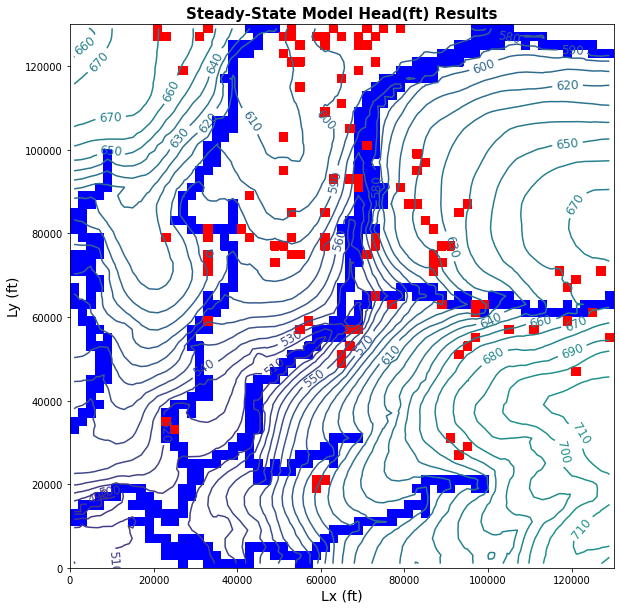

In [1404]:
#Plot potentiometric surface results
plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelmap = flopy.plot.map.PlotMapView(model=m, layer=0) #use plotmapview to attach plot to model
contour_levels = np.linspace(400,1000,61) #set contour levels for contouring head with values from 400-1000 and with 61 divisions
head_contours = modelmap.contour_array(head[9], levels=contour_levels) #create head contours
plt.clabel(head_contours, inline=True,fontsize=12,fmt='%1.0f')
rvr = modelmap.plot_bc(ftype='RIV',color="blue")
well_map = modelmap.plot_bc(ftype='WEL',plotAll=True) #plot the well sites onto the model domain and show with the top layer

#display parameters
plt.xlabel('Lx (ft)',fontsize = 14)
plt.ylabel('Ly (ft)',fontsize = 14)
plt.title('Steady-State Model Head(ft) Results', fontsize = 15, fontweight = 'bold')
plt.show()

# 6 Calibration

## 6A Calibration output

Text(0.5, 1.0, 'Calibration Information')

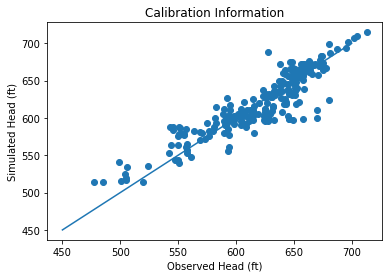

In [1405]:
# import observed well data from csv file
pumping_ob = pd.read_csv('https://raw.githubusercontent.com/dbabrams/ShallowDolomite_Group/master/pumping/SB_Potent_Surface_points.csv?token=AOLRDK2LJEKYREICNO6BFJK64VDE2')

# trim dataframe with well information to the model domain
pumping_ob = pumping_ob.loc[pumping_ob['lambx']<nex]
pumping_ob = pumping_ob.loc[pumping_ob['lamby']<ney]
pumping_ob = pumping_ob[pumping_ob['lambx']>swx]
pumping_ob = pumping_ob[pumping_ob['lamby']>swy]

# convert lamx to column and lamy to row, and convert to grid format
pumping_ob['row'] = np.trunc((ney-pumping_ob['lamby'])/dy)
pumping_ob['col'] = np.trunc((pumping_ob['lambx']-swx)/dx)
# convert to integers
pumping_ob['row'] = pumping_ob.row.astype("int64")
pumping_ob['col'] = pumping_ob.col.astype("int64")

#create column of simulated heads
pumping_ob['simulated']=head[9,pumping_ob['row'],pumping_ob['col']]

#print(pumping_ob)

# compare the observed to simulated pumping data
compare=pumping_ob
compare=compare.set_index('Head_ftAMS')
compare=compare.drop(['row','col'],axis=1)

# create scatterplot with observed on x and simulated on y 
plt.scatter(compare.index,compare.simulated)
x = np.linspace(450,700)
y = x
plt.plot(x,y) #create x=y line to compare
plt.xlabel('Observed Head (ft)')
plt.ylabel('Simulated Head (ft)')
plt.title('Calibration Information')
#print (compare)

In [1406]:
# calculate mean and mean absolute error
pumping_ob['error']=pumping_ob['Head_ftAMS']-pumping_ob['simulated'] #difference between observed and simulated head
pumping_ob['absolute']=pumping_ob.error.abs() #find absolute error
mean=pumping_ob.error.mean() # find mean error
aberror = pumping_ob.absolute.mean()
print("Mean Error:", mean)
print("Mean Absolute Error:", aberror)

Mean Error: 0.5806650516904646
Mean Absolute Error: 14.500150314857219


In [0]:
pumping_ob

,lambx,lamby,Head_ftAMS,row,col,simulated,error,absolute
2,3439284.0,3096459.0,671.00,31,59,652.214722,18.785278,18.785278
3,3447053.0,3101788.0,678.00,29,63,655.220825,22.779175,22.779175
4,3440363.0,3098077.0,675.00,30,60,655.062073,19.937927,19.937927
5,3437211.0,3086796.0,638.00,36,58,667.301147,-29.301147,29.301147
10,3398670.0,3081690.0,607.14,39,39,620.090027,-12.950027,12.950027
...,...,...,...,...,...,...,...,...
1446,3357400.0,3135260.0,602.02,12,18,602.091370,-0.071370,0.071370
1447,3365250.0,3119060.0,597.25,20,22,602.102356,-4.852356,4.852356
1448,3352370.0,3124010.0,582.48,17,16,593.819397,-11.339397,11.339397
1449,3352800.0,3119000.0,590.57,20,16,591.102539,-0.532539,0.532539


## 6B Head Error Map

In [0]:
# convert position of each observed data points from (lambx,lamby) to (long,lat)
for ind in pumping_ob.index: 
  pumping_ob.loc[ind,'lat'], pumping_ob.loc[ind,'long'] = pyproj.transform(illimap,wgs84,pumping_ob.loc[ind,'lambx']*0.3048,pumping_ob.loc[ind,'lamby']*0.3048)
# print(pumping_ob)

# conduct the Universal Kriging
UK = UniversalKriging(pumping_ob['long'], pumping_ob['lat'], pumping_ob['error'],
                      variogram_model='spherical', nlags=6)

# create xpoints and ypoints in space, with 0.01 spacing
xpoints = np.arange(sw_long, ne_long+0.01, 0.01)
ypoints = np.arange(sw_lat, ne_lat+0.01, 0.01)
# create a meshgrid with xpoints and ypoints, to be used later in the code
Xm, Ym = np.meshgrid(xpoints, ypoints)
# calculate the interpolated grid and fill values.
z, var = UK.execute('grid', xpoints, ypoints)
z = z.filled(fill_value=None)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: This function is deprecated. See: https://pyproj4

In [0]:
def error_map(Xm, Ym, z, df, title):
    """
        this function uses the cartopy package to draw error map given the DataFrame
    """
    fig = plt.figure(figsize=(16,12))
    # set projection kind
    ax = plt.axes(projection=ccrs.PlateCarree())
    # set features for different obejects
    states_provinces = cf.NaturalEarthFeature(
      category='cultural', # features are categorized as cultural or physical
      name='admin_1_states_provinces', # name of shapefile
      scale='10m', # scale of features
      facecolor='none')	
    largerivers = cf.NaturalEarthFeature(
      category='physical',
      name='rivers_lake_centerlines',
      scale='110m', # major rivers
      facecolor='none')
    smallrivers = cf.NaturalEarthFeature(
      category='physical',
      name='rivers_lake_centerlines_scale_rank',
      scale='10m', # smaller rivers
      facecolor='none')
    smallestrivers = cf.NaturalEarthFeature(
      category='physical',
      name='rivers_north_america',
      scale='10m', # smallest rivers
      facecolor='none')  
    popplaces = cf.NaturalEarthFeature(
      category='cultural',
      name='urban_areas', # plots municipal boundaries
      scale='10m',
      facecolor='plum')
    majorroads = cf.NaturalEarthFeature(
      category='cultural',
      name='roads',
      scale='10m',
      facecolor='none')
    
    # add defined features into axes
    ax.add_feature(states_provinces, edgecolor='slategray', linewidth=2.0,linestyle=':',zorder=4)
    ax.add_feature(popplaces,color='darkgray',alpha=0.2,linewidth=0.1, zorder=1)
    ax.add_feature(largerivers,edgecolor='aqua',linewidth=6.0)
    ax.add_feature(smallrivers,edgecolor='aqua',linewidth=6.0, zorder=2)
    ax.add_feature(smallestrivers,edgecolor='aqua',linewidth=6.0)
    ax.add_feature(majorroads,edgecolor='black',linewidth=1.0)
    
    # create contours from the interpolation and fill the interval according to given colorbar
    cset = plt.contour(Xm, Ym, z, np.arange(-30, 50, 5), colors='blue')
    C = plt.contourf(Xm, Ym, z, np.arange(-30, 50, 5), alpha=.75,
                         cmap=plt.cm.jet_r)  # reverse of colorbar 'jet'
    
    plt.colorbar(C)
    # contour labels
    plt.clabel(cset, inline=1, fontsize=10, fmt='%1.0f')
    # show well sites on the map
    plt.scatter(df['long'],df['lat'],marker=".",color="black",label='surface points')
    plt.title(title,fontsize=16)
    plt.xlim(sw_long,ne_long)
    plt.ylim(sw_lat,ne_lat)
    plt.legend()
    plt.legend()
    plt.show()

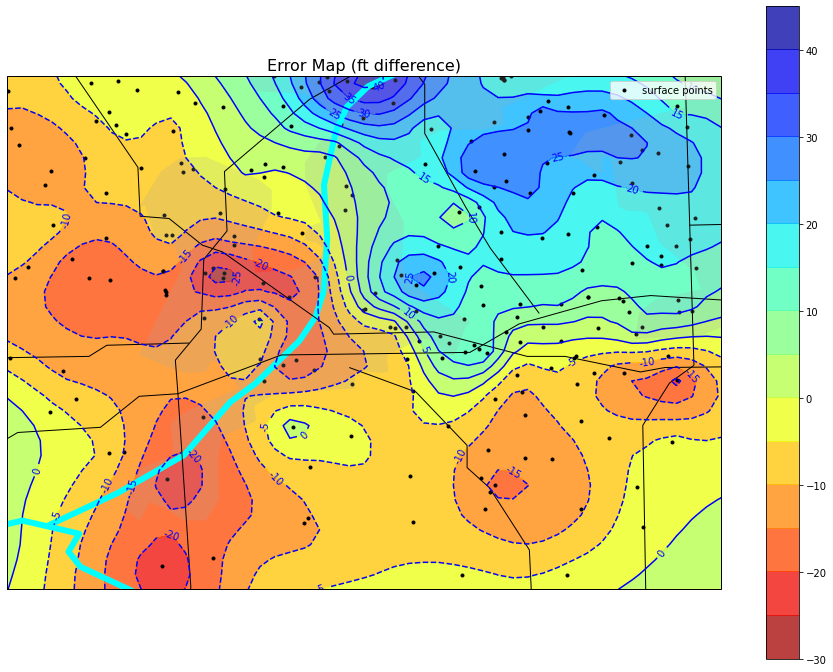

In [0]:
error_map(Xm,Ym,z,pumping_ob,'Error Map (ft difference)')

# 7 Zone Budget

In [0]:
# read budget data from my_model.cbc as a flopy budget object
cbf = flopy.utils.binaryfile.CellBudgetFile(modelname+'.cbc')
cbf.list_records()
frf = cbf.get_data(text='flow right face',totim=1.0)
fff = cbf.get_data(text='flow front face',totim=1.0)
flf = cbf.get_data(text='flow lower face',totim=1.0)

In [0]:
# upload the zonebudget-style(.txt) array file 
from google.colab import files

uploaded = files.upload()

In [0]:
# read_zbarray utility is used to import the zonebudget-style(.txt) array file
# for each layer, there is a 60x30 square, with 1 standing for upper zone and 2 standing for lower zone
# nlay = 10
zon = flopy.utils.read_zbarray('zone_file.txt')

In [0]:
# set zone 1 as "upper half"; zone 2 as "lower half"
aliases = {1:'Upper half', 2:'Lower half'}
# create a ZoneBudget object and get the budget record array
zb = flopy.utils.zonbud.ZoneBudget(cbf, zon, kstpkper=(0,0),aliases=aliases)
zb.get_budget()

In [0]:
# show flow data for both zones in a format of DataFrame
df = zb.get_dataframes(index_key='kstpkper')
print(df)